In [1]:
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

sns.set()

%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col] = df[col].fillna(col_min_value - 1)
                col_min_value -= 1

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                try:
                    if col_min_value >= 0:
                        if col_max_value < 255:
                            df[col] = df[col].astype(np.uint8)
                        elif col_max_value < 65535:
                            df[col] = df[col].astype(np.uint16)
                        elif col_max_value < 4294967295:
                            df[col] = df[col].astype(np.uint32)
                        else:
                            df[col] = df[col].astype(np.uint64)
                    else:
                        if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                            df[col] = df[col].astype(np.int8)
                        elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                            df[col] = df[col].astype(np.int16)
                        elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                            df[col] = df[col].astype(np.int32)
                        elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                            df[col] = df[col].astype(np.int64)
                except Exception as e:
                    print(f'Ошибка конвертации {col}: {e}')

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [3]:
INPUT_DIR = 'data'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))


In [4]:
df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
df_test, df_test_NAlist = reduce_mem_usage(df_test)

100%|██████████| 433/433 [00:00<00:00, 659.44it/s]


In [5]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(30), int8(202), object(31), uint16(22), uint32(3), uint8(66)
memory usage: 379.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(78), int16(40), int8(229), object(31), uint16(24), uint32(3), uint8(28)
memory usage: 157.9+ MB
None


В данных есть пропуски:

In [6]:
print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 4.47002%
Missing data in test: 4.33051%


Заполним пропуски в столбцах, где значения выражаются числами - `-1`, а где строками - `'unseen_category'`.

In [11]:
for col in df_train.columns.drop('isFraud'):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 0.00000%
Missing data in test: 0.00000%


In [12]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(30), int8(202), object(31), uint16(22), uint32(3), uint8(66)
memory usage: 379.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(78), int16(40), int8(229), object(31), uint16(24), uint32(3), uint8(28)
memory usage: 157.9+ MB


(None, None)

Закодируем категориальные признаки с помощью [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) и сконвертируем их в [`category`](https://pandas.pydata.org/pandas-docs/version/0.23.4/categorical.html).

In [13]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])

        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df_train.info(), df_test.info()

100%|██████████| 433/433 [00:10<00:00, 40.75it/s] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(80), int16(30), int8(202), uint16(22), uint32(3), uint8(66)
memory usage: 293.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(78), int16(40), int8(229), uint16(24), uint32(3), uint8(28)
memory usage: 122.5 MB


(None, None)

Перед тем, как обучать какие-либо модели, нужно настроить валидацию - для того, чтобы оценивать обобщающую способность без использования тестовой выборки. Несмотря на то, что модель можно применить к тестовой части и получить результат на лидерборде, отнюдь не факт, что такому результату можно доверять. Дело в том, что он рассчитывается по публичной части тестовой выборки - однако итоговый результат будет рассчитываться по приватной части после окончания соревнования. Распределение данных в публичной и приватной частях может различаться, и если вы будете оценивать качество только по результату на публичной части, может получиться так, что ваше итоговое место в соревновании будет сильно ниже того, что вы имели по ходу.

Однако бывают случаи, когда можно занять топовые места в соревновании и без настройки валидации, доверяя лишь результату на публичной части тестовой выборки. Пример: [описание решения победителя соревнования по детекции диабетической ретинопатии](https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/108065).

Техники валидации могут быть очень разными - от разбиения на обучающую/валидационную часть до [разбиения на группы с перемешиванием](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit). Для кросс-валидации может быть полезно воспользоваться модулем [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) из библиотеки `scikit-learn`.

Настройка корректной валидации очень зависит от поставленной задачи. Очевидно, в идеале нужно выбрать такой способ, который сможет отразить то, насколько хорошо модель справится с приватной частью тестовой выборки.

В ноутбуке с EDA было выдвинуто следующее предположение: согласно поведению признака `TransactionDT`, в обучающей части выборки содержатся данные за 4 месяца. Давайте настроим кросс-валидацию с 4 фолдами, где в каждом случае будем брать в качестве валидационной части тот или иной месяц.

In [14]:
(df_train['TransactionDT'].max() - df_train['TransactionDT'].min()) / (3600 * 24)

120.99996527777778

In [15]:
month_length = 3600 * 24 * 30
df_train['TransactionDT'].shape

(417559,)

In [16]:
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
print('Validation set 0 length:', len(fold0_idx))
print('Validation set 1 length:', len(fold1_idx))
print('Validation set 2 length:', len(fold2_idx))
print('Validation set 3 length:', len(fold3_idx))

Validation set 0 length: 134339
Validation set 1 length: 89399
Validation set 2 length: 92189
Validation set 3 length: 101632


In [17]:
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

In [18]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,99,150,1,142,...,129,-1,260,4,2,2,2,2,2,1774
1,2987001,0,86401,29.0,4,2755,404,150,2,102,...,129,-1,260,4,2,2,2,2,2,1774
2,2987002,0,86469,59.0,4,4663,490,150,4,166,...,129,-1,260,4,2,2,2,2,2,1774
3,2987003,0,86499,50.0,4,18132,567,150,2,117,...,129,-1,260,4,2,2,2,2,2,1774
4,2987004,0,86506,50.0,1,4497,514,150,2,102,...,123,32,164,3,1,0,1,1,1,954


В данных есть признак-идентификатор объекта - `'TransactionID'`. Заметим, что его значения в обучающей и тестовых выборках не пересекаются:

In [19]:
set(df_train['TransactionID']).intersection(set(df_test['TransactionID']))

set()

Также не пересекаются значения признака, отвечающего за момент времени - `'TransactionDT'`:

In [20]:
set(df_train['TransactionDT']).intersection(set(df_test['TransactionDT']))

set()

В связи с этим удалим эти признаки, чтобы модель их не учитывала.

In [21]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

Обучимся с помощью [`lightgbm`](https://lightgbm.readthedocs.io/en/latest/), и для каждой модели сделаем предсказание на тестовой выборке. Также будем сохранять важности признаков на каждом фолде.


In [24]:
import catboost as cb
from catboost import CatBoostClassifier, Pool

In [56]:
%%time

cat_features = df_train.select_dtypes(include=['category']).columns.tolist()

params = {
    'objective': 'Logloss',
    'learning_rate': 0.2,
    'iterations': 2000,
    'random_seed': 42,
    'early_stopping_rounds': 200,
    'verbose': 200,
    # 'task_type': "GPU",
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in tqdm(range(len(folds_idx))):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    cb_train = cb.Pool(X_train, y_train, cat_features=cat_features)
    cb_eval = cb.Pool(X_val, y_val, cat_features=cat_features)
    
    model = CatBoostClassifier(**params)
    model.fit(cb_train, eval_set=cb_eval)

    feature_importances['fold_{}'.format(i)] = model.feature_importances_

    y_pred = model.predict_proba(X_val)[:, 1]
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    print(f'Fold {i}, AUC-ROC: {score_fold:.5f}')
    y_test_pred = model.predict_proba(df_test)[:, 1]
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print(f'Fold {i}, AUC-ROC: {scores[i]:.5f}')
print(f'CV AUC-ROC: {np.mean(scores):.5f}')

  0%|          | 0/4 [00:00<?, ?it/s]

0:	learn: 0.4095527	test: 0.4200374	best: 0.4200374 (0)	total: 430ms	remaining: 14m 19s
200:	learn: 0.0737961	test: 0.0911515	best: 0.0872947 (152)	total: 1m 9s	remaining: 10m 23s
400:	learn: 0.0628279	test: 0.0854194	best: 0.0847674 (387)	total: 2m 19s	remaining: 9m 15s


In [40]:
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3
0,TransactionAmt,3.298389,3.305623,3.535427,3.072422
1,ProductCD,0.288250,0.261268,0.365038,0.550113
2,card1,2.786398,4.497560,4.658848,4.107217
3,card2,3.692771,4.479248,4.682370,3.843060
4,card3,1.543990,0.957506,1.552379,1.050940


Для итоговой оценки важности признаков усредним важности признаков на фолдах.

In [41]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3,average
0,TransactionAmt,3.298389,3.305623,3.535427,3.072422,3.302965
1,ProductCD,0.288250,0.261268,0.365038,0.550113,0.366167
2,card1,2.786398,4.497560,4.658848,4.107217,4.012506
3,card2,3.692771,4.479248,4.682370,3.843060,4.174362
4,card3,1.543990,0.957506,1.552379,1.050940,1.276204


/var/folders/f2/942c2cl91r9877yf8jj8c15xr94h9h/T/ipykernel_56645/175549146.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


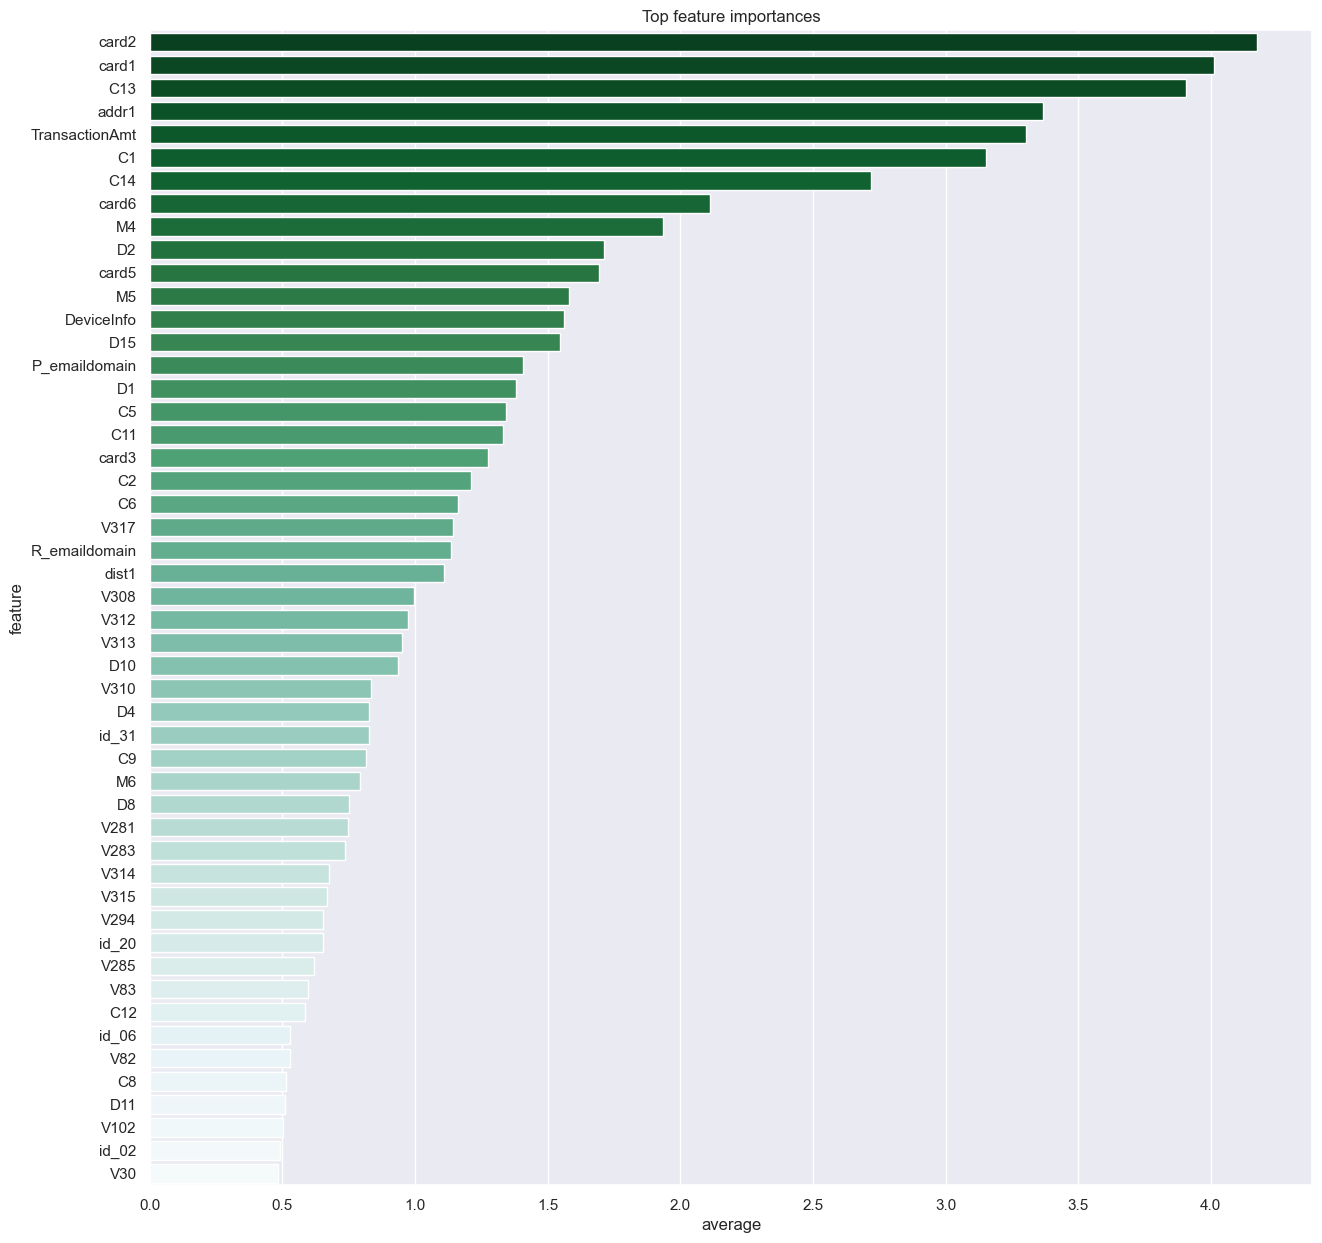

In [42]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

Для получения итогового предсказания на тестовой выборке усредним предсказания моделей с разных фолдов.

In [43]:
np.array(test_preds).shape

(4, 172981)

In [44]:
final_pred = np.average(test_preds, axis=0)
final_pred

array([0.00905215, 0.11891511, 0.02737017, ..., 0.00314109, 0.02393854,
       0.00987064])

In [45]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.head()

,TransactionID,isFraud
0,3404559,0.009052
1,3404560,0.118915
2,3404561,0.027370
3,3404562,0.015270
4,3404563,0.328061


In [46]:
sub.tail()

,TransactionID,isFraud
172976,3577535,0.018456
172977,3577536,0.014827
172978,3577537,0.003141
172979,3577538,0.023939
172980,3577539,0.009871


Сохраняем файл с предсказаниями - теперь его можно отправить в соревнование и посмотреть результат на публичной части.

In [47]:
sub.to_csv('data/submission_base_catboost.csv', index=False)  # Leaderboard: 0.90140

Наконец, построим распределение предсказаний для целевой переменной на тестовой выборке.

In [48]:
# Отправка файла на соревнование
!kaggle competitions submit -c fraud-detection-24 -f data/submission_base_catboost.csv -m "Базовая модель CatBoost"

100%|██████████████████████████████████████| 4.75M/4.75M [00:02<00:00, 2.12MB/s]
Successfully submitted to Fraud Detection Competition

Кaggle score 0.90140

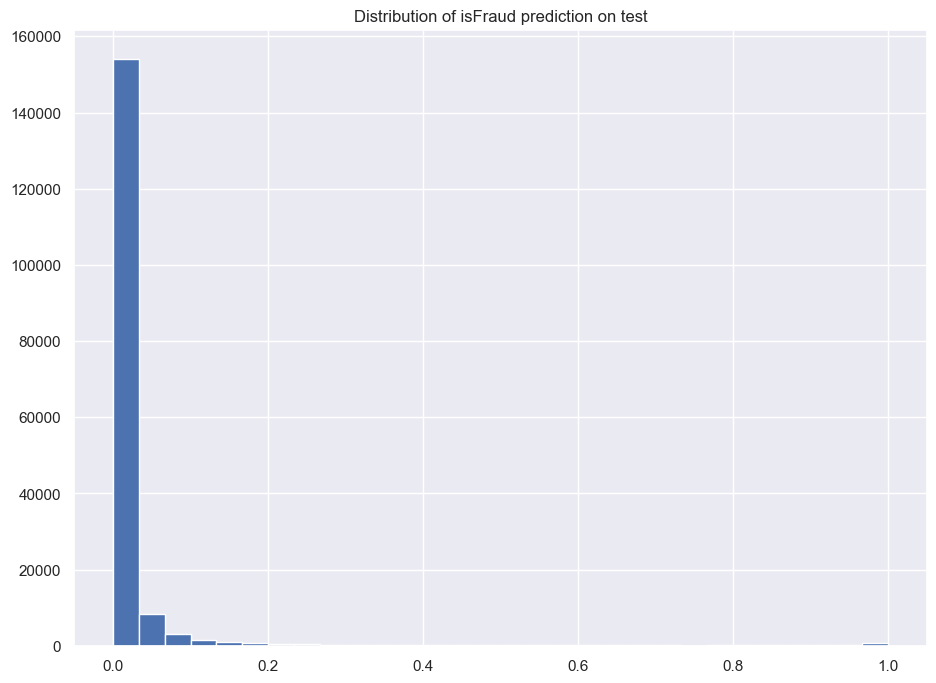

In [48]:
plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()